In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [2]:
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)

In [3]:
# merger.convert_deaths_df()
df = merger.merge_deaths_df()

/opt/conda/lib/python3.7/site-packages/pyarrow/compat.py:25: FutureWarning: pyarrow.compat has been deprecated and will be removed in a future release
  "future release", FutureWarning)


In [53]:
list(df["date"].unique())

[Timestamp('2020-03-31 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-04-02 00:00:00'),
 Timestamp('2020-04-03 00:00:00'),
 Timestamp('2020-04-04 00:00:00'),
 Timestamp('2020-04-05 00:00:00'),
 Timestamp('2020-04-06 00:00:00'),
 Timestamp('2020-04-07 00:00:00'),
 Timestamp('2020-04-08 00:00:00'),
 Timestamp('2020-04-09 00:00:00'),
 Timestamp('2020-04-10 00:00:00'),
 Timestamp('2020-04-11 00:00:00'),
 Timestamp('2020-04-12 00:00:00'),
 Timestamp('2020-04-13 00:00:00'),
 Timestamp('2020-04-14 00:00:00'),
 Timestamp('2020-04-15 00:00:00'),
 Timestamp('2020-04-16 00:00:00'),
 Timestamp('2020-04-17 00:00:00'),
 Timestamp('2020-04-18 00:00:00'),
 Timestamp('2020-04-19 00:00:00'),
 Timestamp('2020-04-20 00:00:00'),
 Timestamp('2020-04-21 00:00:00'),
 Timestamp('2020-04-22 00:00:00'),
 Timestamp('2020-04-23 00:00:00'),
 Timestamp('2020-04-24 00:00:00'),
 Timestamp('2020-04-25 00:00:00'),
 Timestamp('2020-04-26 00:00:00'),
 Timestamp('2020-04-27 00:00:00'),
 Timestamp('2020-04-

In [5]:
df_additional = merger.df["details"][["date","additional.infected"]].set_index("date")

In [6]:
df_tests = merger.show_kpi_hu()[["tests"]].reset_index()
df_tests["index"] = pd.to_datetime(df_tests["index"], format='%Y-%m-%d').dt.date
df_tests["additional.tests"] = df_tests.apply(
    lambda row: row["tests"]-df_tests[
        df_tests["index"]==row["index"] - pd.Timedelta(1, unit='D')
    ]["tests"].max(), 
    axis=1
)
df_tests = df_tests.set_index("index")

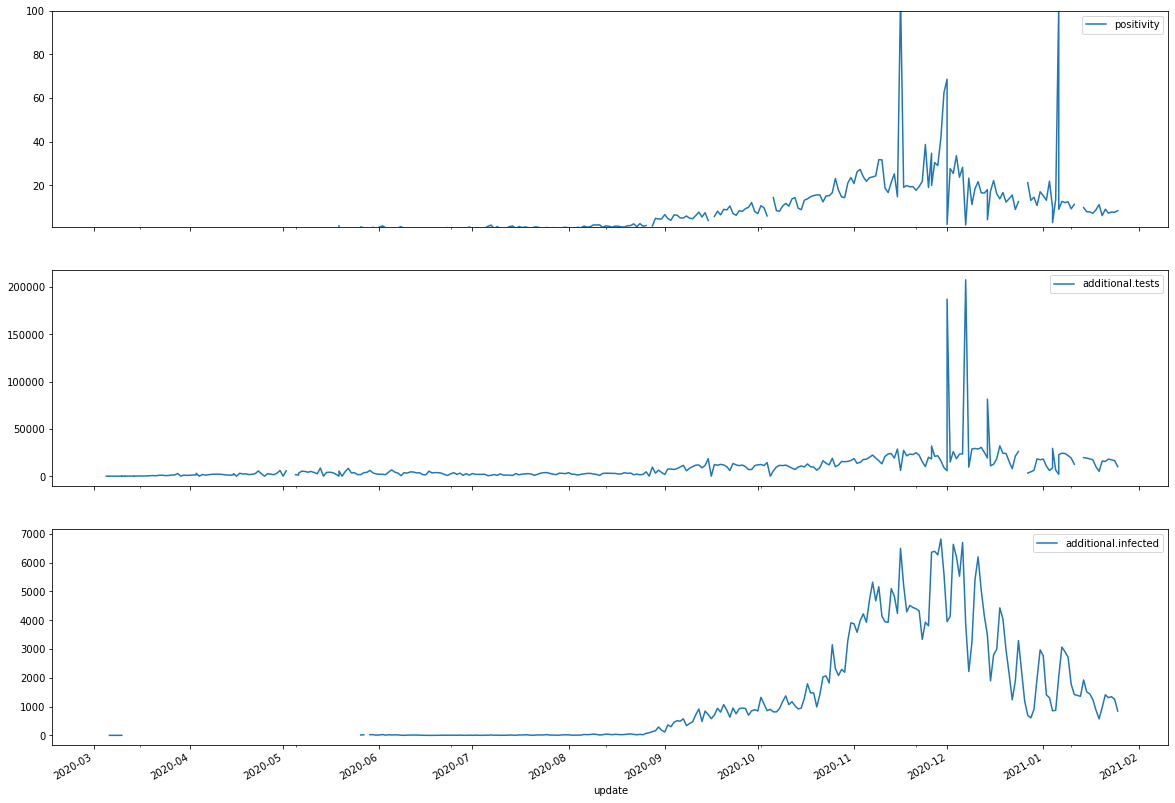

In [7]:
df_join = df_tests.join(df_additional).reset_index()
df_join["positivity"] = df_join["additional.infected"]/df_join["additional.tests"]*100
df_join["Country/Region"] = "HU"
df_join["update"] = df_join["index"]
(fig, ax) = plt.subplots(figsize=(20,15), nrows=3, sharex=True)
ax[0].set_ylim(1,100)
df_join.plot(x="update", y="positivity", ax=ax[0])
df_join.plot(x="update", y="additional.tests", ax=ax[1])
df_join.plot(x="update", y="additional.infected", ax=ax[2])
plt.show()

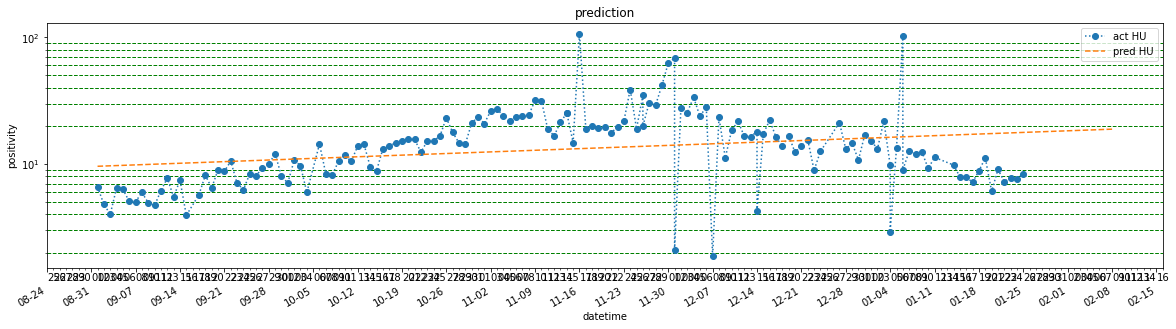

Coefficient of determination: {'HU': 0.07170513085415764}
Evolution factor per day: {'HU': 1.0}
Doubling in day(s): {'HU': 2.0}


,index,tests,additional.tests,additional.infected,positivity,Country/Region,update
363,2021-01-21,3000325.0,15577.0,1410.0,9.051807,HU,2021-01-21
364,2021-01-22,3018389.0,18064.0,1311.0,7.257529,HU,2021-01-22
365,2021-01-23,3035627.0,17238.0,1344.0,7.796728,HU,2021-01-23
366,2021-01-24,3052068.0,16441.0,1257.0,7.645520,HU,2021-01-24
367,2021-01-25,3062132.0,10064.0,844.0,8.386328,HU,2021-01-25


In [8]:
tmpDf = md.DataProcessing.Analyse.start_analyse(
    df_join[
        (df_join["additional.tests"]>0) & (df_join["index"]>=pd.Timestamp("2020-09-01"))
    ].dropna(),
    ["HU"],
    "positivity", 
    "positivity"
)
df_join.tail()

# Check plausibility

In [9]:
# Details
selected_details_df = merger.df["details"][[
    "date", "additional.infected", "additional.deaths", 
    "cumulated.infected", "cumulated.recoveredFromHospital", 
    "onVentilator", "hospital", "active.infected"
]].copy()
selected_details_df.columns = [
    "date", "news.add.infected", "news.add.deaths", 
    "news.cum.infected", "news.cum.recovered", 
    "news.onVentilator", "news.hospital", "news.active"
]
selected_details_df["date"] = pd.to_datetime(selected_details_df["date"], format='%Y-%m-%d').dt.date
selected_details_df["news.add.recovered"] = selected_details_df.apply(
    lambda row: row["news.cum.recovered"] - selected_details_df[
        selected_details_df["date"]<row["date"]
    ]["news.cum.recovered"].max(), axis=1
)
selected_details_df = selected_details_df.set_index("date")

# KPI
selected_kpi_df = merger.show_kpi_hu()[["infected"]].copy().reset_index()
selected_kpi_df.columns = ["date", "kpi.cum.infected"]
selected_kpi_df["date"] = pd.to_datetime(selected_kpi_df["date"], format='%Y-%m-%d').dt.date
selected_kpi_df = selected_kpi_df.set_index("date")

selected_details_df.join(selected_kpi_df).tail()

,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,kpi.cum.infected
date,,,,,,,,,
2021-01-21,1410.0,98.0,355662,235276.0,286.0,4049.0,108673.0,2044.0,355662.0
2021-01-22,1311.0,98.0,356973,237362.0,274.0,3959.0,107800.0,2086.0,356973.0
2021-01-23,1344.0,93.0,358317,239880.0,259.0,3854.0,106533.0,2518.0,358317.0
2021-01-24,1257.0,64.0,359574,241472.0,254.0,3793.0,106134.0,1592.0,359574.0
2021-01-25,844.0,56.0,360418,243092.0,247.0,3814.0,105302.0,1620.0,360418.0


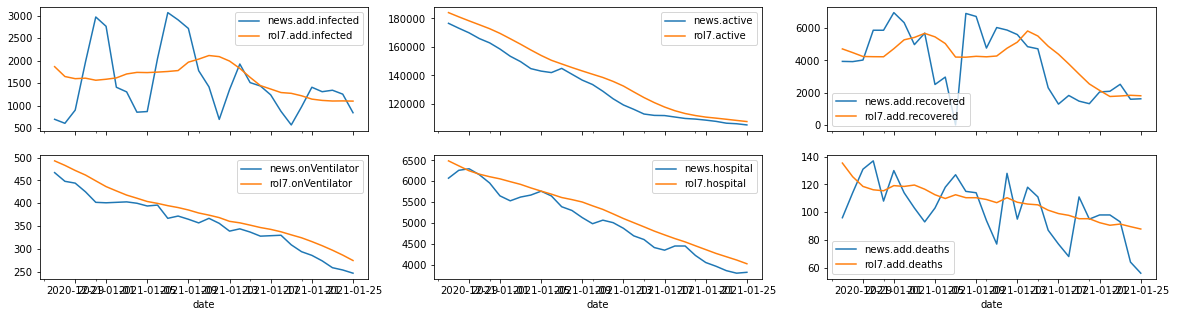

In [10]:
(fig, ax) = plt.subplots(figsize=(20,5), nrows=2, ncols=3, sharex=True)
plot_df = selected_details_df
configuration = {
    "add.infected":(0, 0), "onVentilator":(1,0),   # 1st col
    "active":(0,1),        "hospital":(1,1),       # 2nd col
    "add.recovered":(0,2), "add.deaths":(1,2)      # 3rd col
}
for category in configuration:
    plot_df["rol7.{}".format(category)] = plot_df.rolling(7).mean()[["news.{}".format(category)]]
plot_df = plot_df.reset_index().tail(30)

for (category, position) in configuration.items():
    my_ax = ax[position[0]][position[1]]
    plot_df.plot(x="date", y="news.{}".format(category), ax=my_ax)
    plot_df.plot(x="date", y="rol7.{}".format(category), ax=my_ax)
plt.show()

In [11]:
#plot_df["add.infected"] = plot_df.apply(lambda row: plot_df[plot_df["date"]<], axis=1)
#plot_df.head()
plot_df.tail(10)

,date,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,rol7.add.infected,rol7.onVentilator,rol7.active,rol7.hospital,rol7.add.recovered,rol7.add.deaths
316,2021-01-16,1438.0,87.0,350587,227325.0,328.0,4408.0,111998.0,2304.0,1446.857143,346.857143,120969.000000,4802.428571,4879.000000,101.428571
317,2021-01-17,1241.0,77.0,351828,228615.0,329.0,4345.0,111872.0,1290.0,1370.142857,342.857143,117857.428571,4711.714286,4382.714286,99.000000
318,2021-01-18,875.0,68.0,352703,230441.0,330.0,4445.0,110853.0,1826.0,1292.428571,337.571429,115270.857143,4623.142857,3781.285714,97.714286
319,2021-01-19,573.0,111.0,353276,231915.0,309.0,4445.0,109841.0,1474.0,1274.857143,330.857143,113298.571429,4543.142857,3151.857143,95.285714
320,2021-01-20,976.0,95.0,354252,233232.0,294.0,4218.0,109405.0,1317.0,1220.285714,324.428571,111883.714286,4450.000000,2539.857143,95.285714
321,2021-01-21,1410.0,98.0,355662,235276.0,286.0,4049.0,108673.0,2044.0,1146.571429,316.142857,110799.000000,4358.571429,2138.857143,92.428571
322,2021-01-22,1311.0,98.0,356973,237362.0,274.0,3959.0,107800.0,2086.0,1117.714286,307.142857,110063.142857,4267.000000,1763.000000,90.571429
323,2021-01-23,1344.0,93.0,358317,239880.0,259.0,3854.0,106533.0,2518.0,1104.285714,297.285714,109282.428571,4187.857143,1793.571429,91.428571
324,2021-01-24,1257.0,64.0,359574,241472.0,254.0,3793.0,106134.0,1592.0,1106.571429,286.571429,108462.714286,4109.000000,1836.714286,89.571429
325,2021-01-25,844.0,56.0,360418,243092.0,247.0,3814.0,105302.0,1620.0,1102.142857,274.714286,107669.714286,4018.857143,1807.285714,87.857143


In [47]:
baseDf = pd.read_csv("data/map_data/map_dataframe_per_megye.csv", delimiter=",")[['date','region','confirmed']]
# Convert date column and add week/dayofweek
baseDf['date'] =  pd.to_datetime(baseDf['date'], format='%Y-%m-%d')
last_kpi = baseDf[baseDf["date"].isin(["2021-01-04","2021-01-11","2021-01-18","2021-01-25"])].pivot(
    index="region",
    columns="date",
    values="confirmed"
)
last_kpi.columns = ["01_04", "01_11", "01_18", "01_25"]
last_kpi["w_2"] = last_kpi["01_11"] - last_kpi["01_04"]
last_kpi["w_1"] = last_kpi["01_18"] - last_kpi["01_11"]
last_kpi["w_0"] = last_kpi["01_25"] - last_kpi["01_18"]
last_kpi

,01_04,01_11,01_18,01_25,w_2,w_1,w_0
region,,,,,,,
Baranya,10658,11567,12118,12609,909,551,491
Borsod-Abaúj-Zemplén,18651,19276,19722,20125,625,446,403
Budapest,62579,64603,65923,67068,2024,1320,1145
Bács-Kiskun,14967,15701,16201,16584,734,500,383
Békés,11222,11685,11883,12108,463,198,225
Csongrád,15110,15777,16175,16501,667,398,326
Fejér,11956,12853,13377,13845,897,524,468
Győr-Moson-Sopron,18950,19586,19980,20246,636,394,266
Hajdú-Bihar,18847,19576,20028,20389,729,452,361
